In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv('wr_final.csv')
df = df.drop(columns=['Unnamed: 0', '3 Cone', 'Shuttle', 'Vertical Jump', 'Position', 'PK', 'Year', 'RushAvg'])

In [3]:
df.head()

Round  Pick Team          Player   Age              School  Weight  \
0      1     6  STL      Torry Holt  23.0  North Carolina St.   192.0   
1      1     8  ARI    David Boston  21.0            Ohio St.   215.0   
2      1    13  PIT    Troy Edwards  22.0      Louisiana Tech   191.0   
3      2    32  CLE   Kevin Johnson  23.0            Syracuse   194.0   
4      2    53  BUF  Peerless Price  22.0           Tennessee   180.0   

   40 Time  Height (in)     G  ...  RushAtt  RushYds  RushTD  Plays  TotalYds  \
0     4.44         72.3  29.0  ...     11.0    117.0     0.0  185.0    3235.0   
1     4.47         73.3  25.0  ...      3.0      8.0     0.0  161.0    2413.0   
2     4.57         69.5  34.0  ...     38.0    447.0     6.0  318.0    4799.0   
3     4.41         71.1  11.0  ...      8.0    105.0     3.0   68.0     999.0   
4     4.55         70.9  35.0  ...      7.0    122.0     1.0  148.0    2349.0   

   YardsPerPlay  TotalTDs         YPG      Conf  response  
0     17.486486      30.0  107.517241       ACC       1.0  
1     14.987578      27.0   96.200000   Big Ten       1.0  
2     15.091195      56.0  128.000000       Ind       3.0  
3     14.691176      12.0   81.272727  Big East       1.0  
4     15.871622      20.0   63.628571       SEC       2.0  

[5 rows x 24 columns]

In [4]:
df = df[(df['response'].notna()) & (df['RecYds'].notna())]
df.isna().sum()

Round            0
Pick             0
Team             0
Player           0
Age              0
School           0
Weight          30
40 Time         46
Height (in)     30
G                0
Rec              0
RecYds           0
RecAvg           0
RecTD            0
RushAtt          0
RushYds          0
RushTD           0
Plays            0
TotalYds         0
YardsPerPlay     0
TotalTDs         0
YPG              0
Conf             0
response         0
dtype: int64

In [5]:
df.shape

(473, 24)

In [6]:
# removing outliers
df = df[(np.abs(stats.zscore(df['Rec'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RecYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RecTD'])) < 3)]
df = df[(np.abs(stats.zscore(df['TotalYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushAtt'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushTD'])) < 3)]
df.shape

(436, 24)

In [7]:
# setting missing values
df = df.copy()
# df.loc[df['RushAvg'].isna(), 'RushAvg'] = 0
df.loc[df['Weight'].isna(), 'Weight'] = df['Weight'].median()
df.loc[df['40 Time'].isna(), '40 Time'] = df['40 Time'].median()
df.loc[df['Height (in)'].isna(), 'Height (in)'] = df['Height (in)'].median()

In [8]:
# seperating features and response
response = df['response']
df = df.drop(columns = ['Player'])

In [9]:
# sns.set_theme()
display(print("Round Correlation: ", df['response'].corr(df['Round'])))
display(print("Pick Correlation: ", df['response'].corr(df['Pick'])))
display(print("Weight Correlation: ", df['response'].corr(df['Weight'])))
display(print("Height Correlation: ", df['response'].corr(df['Height (in)'])))
display(print("40 Time Correlation: ", df['response'].corr(df['40 Time'])))
display(print("RecYds Correlation: ", df['response'].corr(df['RecYds'])))
display(print("RecAvg Correlation: ", df['response'].corr(df['RecAvg'])))

Round Correlation:  0.5529172020571946


None

Pick Correlation:  0.5529314351799848


None

Weight Correlation:  -0.16839907038102403


None

Height Correlation:  -0.16441395117076063


None

40 Time Correlation:  0.16842757802888486


None

RecYds Correlation:  -0.10741603525256362


None

RecAvg Correlation:  -0.13587852312060278


None

In [10]:
# seperating data into numeric and categorical columns
df_cat = df[['Team', 'School', 'Conf']].copy()
df_num = df.drop(columns = ['Team', 'School', 'Conf']).copy()
response = df['response']

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_num.corr())
# df_num.corr()

                 Round      Pick       Age    Weight   40 Time  Height (in)  \
Round         1.000000  0.984893  0.205570 -0.106944  0.276387    -0.053393   
Pick          0.984893  1.000000  0.187624 -0.088029  0.269241    -0.032547   
Age           0.205570  0.187624  1.000000 -0.206989  0.021661    -0.142701   
Weight       -0.106944 -0.088029 -0.206989  1.000000  0.135084     0.727847   
40 Time       0.276387  0.269241  0.021661  0.135084  1.000000     0.127806   
Height (in)  -0.053393 -0.032547 -0.142701  0.727847  0.127806     1.000000   
G            -0.062971 -0.083555  0.023328 -0.104921  0.036952    -0.178626   
Rec          -0.111333 -0.138469  0.011413 -0.090673  0.130989    -0.173102   
RecYds       -0.204455 -0.223944  0.031001 -0.088373  0.091784    -0.136236   
RecAvg       -0.231506 -0.208475  0.069239 -0.001772 -0.126302     0.103969   
RecTD        -0.311311 -0.321779 -0.024976 -0.056497  0.030592    -0.101081   
RushAtt      -0.071107 -0.087220  0.020821 -0.166353

(array([ 78.,   0.,   0.,  79.,   0.,   0., 215.,   0.,   0.,  64.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

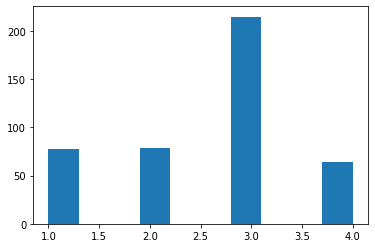

In [12]:
plt.hist(df['response'], bins=10)

(array([72., 78., 83., 82., 51., 38., 32.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <BarContainer object of 7 artists>)

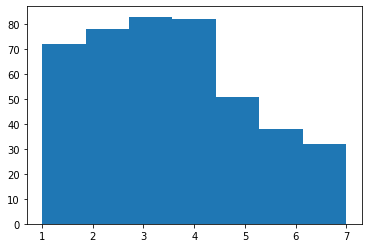

In [13]:
plt.hist(df['Round'], bins=7)

In [14]:
plt.hist(df['Pick'], bins=10)

(array([62., 64., 61., 71., 43., 37., 33., 26., 21., 18.]),
 array([  2. ,  27.6,  53.2,  78.8, 104.4, 130. , 155.6, 181.2, 206.8,
        232.4, 258. ]),
 <BarContainer object of 10 artists>)

In [15]:
plt.hist(df.Weight)

(array([20., 16., 52., 75., 94., 57., 77., 31., 12.,  2.]),
 array([164. , 171.6, 179.2, 186.8, 194.4, 202. , 209.6, 217.2, 224.8,
        232.4, 240. ]),
 <BarContainer object of 10 artists>)

(array([  5.,  22.,  17.,  33.,  59., 183.,  58.,  30.,  24.,   5.]),
 array([66. , 67.2, 68.4, 69.6, 70.8, 72. , 73.2, 74.4, 75.6, 76.8, 78. ]),
 <BarContainer object of 10 artists>)

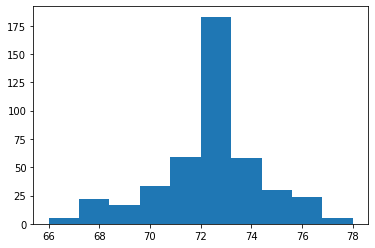

In [16]:
plt.hist(df['Height (in)'])

(array([  4.,  20.,  24.,  76., 124.,  94.,  59.,  21.,  12.,   2.]),
 array([4.22 , 4.276, 4.332, 4.388, 4.444, 4.5  , 4.556, 4.612, 4.668,
        4.724, 4.78 ]),
 <BarContainer object of 10 artists>)

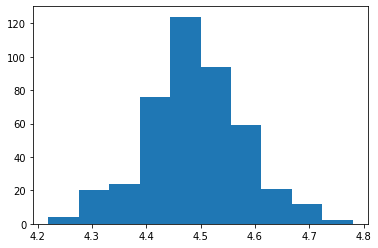

In [17]:
plt.hist(df['40 Time'])

(array([34., 59., 69., 63., 87., 48., 42., 24.,  7.,  3.]),
 array([ 340. ,  753.2, 1166.4, 1579.6, 1992.8, 2406. , 2819.2, 3232.4,
        3645.6, 4058.8, 4472. ]),
 <BarContainer object of 10 artists>)

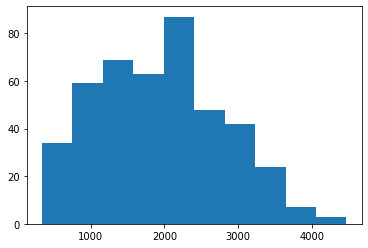

In [18]:
plt.hist(df.RecYds)

(array([ 14.,  85., 139., 132.,  45.,  16.,   4.,   0.,   0.,   1.]),
 array([ 9.65354331, 11.6167604 , 13.5799775 , 15.5431946 , 17.5064117 ,
        19.4696288 , 21.43284589, 23.39606299, 25.35928009, 27.32249719,
        29.28571429]),
 <BarContainer object of 10 artists>)

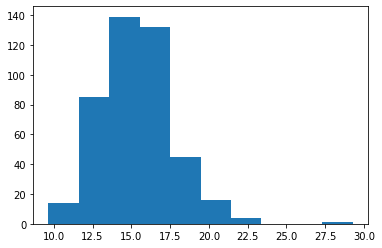

In [19]:
plt.hist(df.RecAvg)

In [20]:
plt.hist(df.RushYds)

(array([188., 103.,  52.,  50.,   9.,  14.,   9.,   4.,   4.,   3.]),
 array([-20. ,  22.1,  64.2, 106.3, 148.4, 190.5, 232.6, 274.7, 316.8,
        358.9, 401. ]),
 <BarContainer object of 10 artists>)

(array([ 14.,  85., 139., 132.,  45.,  16.,   4.,   0.,   0.,   1.]),
 array([ 9.65354331, 11.6167604 , 13.5799775 , 15.5431946 , 17.5064117 ,
        19.4696288 , 21.43284589, 23.39606299, 25.35928009, 27.32249719,
        29.28571429]),
 <BarContainer object of 10 artists>)

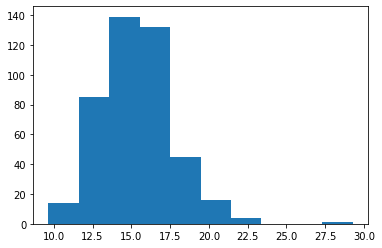

In [21]:
plt.hist(df_num.RecAvg)

(array([  6.,  38.,  93., 156.,  84.,  40.,  15.,   2.,   1.,   1.]),
 array([ 8.24719101, 10.07559691, 11.90400281, 13.73240871, 15.56081461,
        17.38922051, 19.2176264 , 21.0460323 , 22.8744382 , 24.7028441 ,
        26.53125   ]),
 <BarContainer object of 10 artists>)

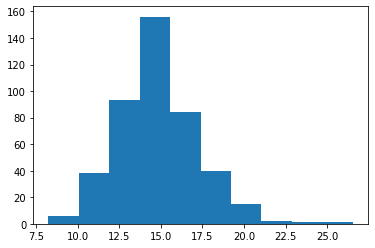

In [22]:
plt.hist(df_num.YardsPerPlay)

In [23]:
plt.hist(df_num.RushTD)

(array([284.,   0.,   0., 105.,   0.,   0.,  27.,   0.,   0.,  20.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

In [24]:
plt.hist(df_num.Rec)

(array([49., 74., 71., 66., 76., 41., 41., 13.,  3.,  2.]),
 array([ 25. ,  55.2,  85.4, 115.6, 145.8, 176. , 206.2, 236.4, 266.6,
        296.8, 327. ]),
 <BarContainer object of 10 artists>)

In [25]:
# creating training and testing data for catboost model
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(df.drop(columns='response'), response, test_size=.2)

In [26]:
X_train_cb.dtypes

Round             int64
Pick              int64
Team             object
Age             float64
School           object
Weight          float64
40 Time         float64
Height (in)     float64
G               float64
Rec             float64
RecYds          float64
RecAvg          float64
RecTD           float64
RushAtt         float64
RushYds         float64
RushTD          float64
Plays           float64
TotalYds        float64
YardsPerPlay    float64
TotalTDs        float64
YPG             float64
Conf             object
dtype: object

In [27]:
# initiating model
# cat_model = CatBoostClassifier(iterations=2,
#                           depth=2,
#                           learning_rate=1,
#                           loss_function='MultiClass',
#                           verbose=True)
cat_model = CatBoostClassifier()
# using grid search to determine best parameters
grid = {'iterations': [1, 2, 3, 4, 5],
        'depth': [1, 2, 4, 6, 10],
        'learning_rate': [.3, .7, 1]}

# Pooling data before fitting
pool_train = Pool(X_train_cb, y_train_cb, cat_features=['Team', 'School', 'Conf'])

gs_result = cat_model.grid_search(grid, pool_train, plot=True)

# fitting model
# cat_model.fit(pool_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3121798	test: 1.3252744	best: 1.3252744 (0)	total: 136ms	remaining: 0us

bestTest = 1.325274403
bestIteration = 0

0:	loss: 1.3252744	best: 1.3252744 (0)	total: 172ms	remaining: 12.7s
0:	learn: 1.2558736	test: 1.2865592	best: 1.2865592 (0)	total: 740us	remaining: 0us

bestTest = 1.286559232
bestIteration = 0

1:	loss: 1.2865592	best: 1.2865592 (1)	total: 174ms	remaining: 6.36s
0:	learn: 1.2480307	test: 1.2920755	best: 1.2920755 (0)	total: 612us	remaining: 0us

bestTest = 1.292075481
bestIteration = 0

2:	loss: 1.2920755	best: 1.2865592 (1)	total: 176ms	remaining: 4.22s
0:	learn: 1.3121798	test: 1.3252744	best: 1.3252744 (0)	total: 568us	remaining: 568us
1:	learn: 1.1946000	test: 1.2520378	best: 1.2520378 (1)	total: 1.13ms	remaining: 0us

bestTest = 1.252037811
bestIteration = 1

3:	loss: 1.2520378	best: 1.2520378 (3)	total: 178ms	remaining: 3.17s
0:	learn: 1.2558736	test: 1.2865592	best: 1.2865592 (0)	total: 593us	remaining: 593us
1:	learn: 1.0812390	test: 1.2026874	best: 1

In [28]:
# pooling test data
pool_test = Pool(X_test_cb, y_test_cb, cat_features=['Team', 'School', 'Conf'])

# making predictions
cat_preds = cat_model.predict(pool_test)
cat_proba = cat_model.predict_proba(pool_test)

In [29]:
display(f1_score(y_test_cb, cat_preds, average='macro'))

0.5375750108613012

In [30]:
# saving the initial model to a pkl file
wr_pickled_initial = pickle.dump(cat_model, open('wr_pickled_initial.pkl', 'wb'))